In [1]:
import las2 as las
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# function to read a .las file, using the las2 package:
# returns a dictionary where the keys are log's names and values are arrays
def read_well(well_path):
    data = las.read(well_path)
    for i in range(len(data['curve'])):
        if data['curve'][i]['mnemonic'] == 'DEPTH':
            depth = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'GR':
            gr = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'NPHI':
            nphi = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'RHOB':
            rhob = data['data'][i]
            
    curves = {'Depth': depth,
              'GR': gr,
              'NPHI': nphi,
              'RHOB': rhob}
    return curves

In [10]:
#reading the .las file
well_path = "../data/7-MP-28D-BA.las"
data = read_well(well_path)

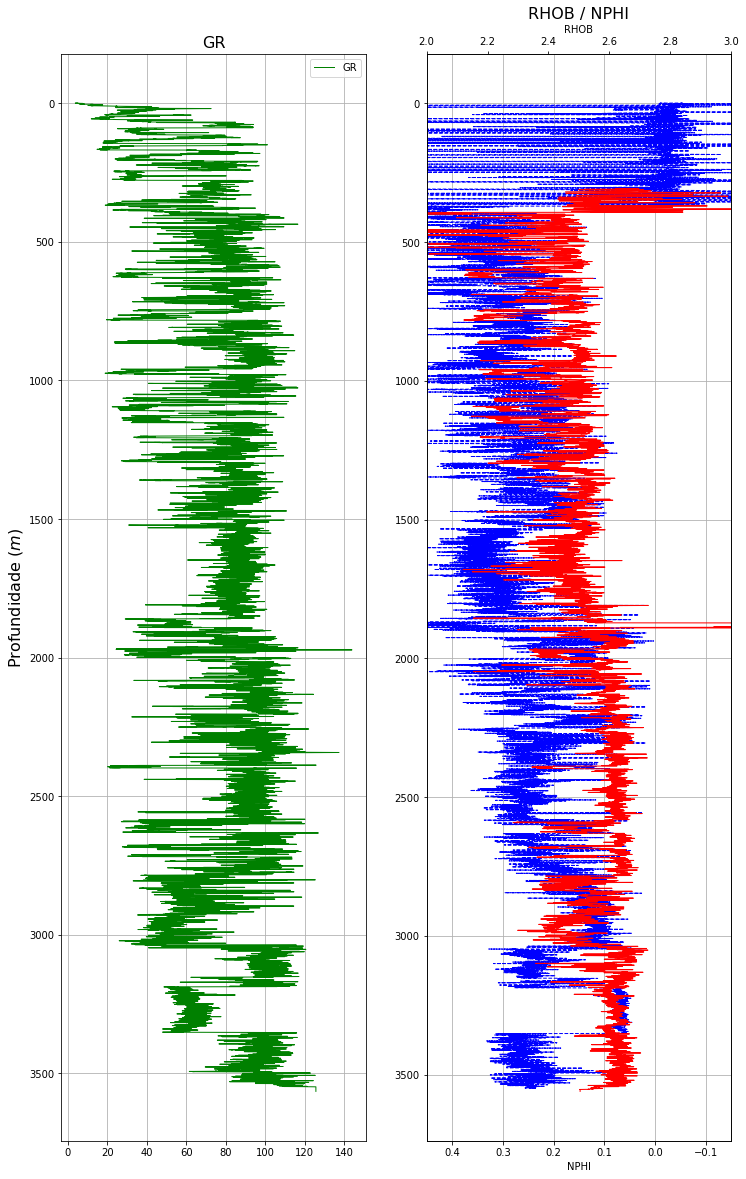

In [11]:
### Plots

fig, (ax1, ax2) = plt.subplots(1,2) # 2 tracks
fig.set_size_inches(12, 20) # Figure size | inches

#_____________________________________________________#
####GR####
ax1.plot(data['GR'],data['Depth'],'-g',linewidth = 1,label='GR')
ax2.set_xlim([0.0, 150.0])
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
ax1.set_title('GR', fontsize=16)
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####NPHI####
ax2.plot(data['NPHI'], data['Depth'],'--b',linewidth = 1,label='NPHI')
ax2.set_xlim([0.45, -0.15])
ax2.set_xlabel('NPHI')
ax2.invert_yaxis()
ax2.grid()
ax2.set_title('RHOB / NPHI', fontsize=16)

#_____________________________________________________#
####RHOB####
ax3 = ax2.twiny() #share y axe
ax3.plot(data['RHOB'], data['Depth'],'-r',linewidth = 1,label='RHOB')
ax3.set_xlim([2.0, 3.0])
ax3.set_xlabel('RHOB')

plt.show()

## Cálculo do DRDN para interpretar a Litologia

In [12]:
# fuction to calculate the DRDN curve
def drdn_log (rhob, nphi):
    drdn = ((rhob-2)/0.05) - ((0.45 - nphi)/0.03)
    return drdn

In [13]:
#calculating the DRDN curve
drdn = drdn_log(data['RHOB'], data['NPHI'])
data['DRDN'] = drdn

In [14]:
lit_py = np.zeros(len(data['DRDN']))

# using the DRDN curve to interpret lithology 
for i in range(len(data['DRDN'])):
    if data['DRDN'][i] < -1.0000:
        lit_py[i] = 49.0000
        
    if data['DRDN'][i] >= -1.0000 and data['DRDN'][i] < -0.3000 :
        lit_py[i] = 25.0000
        
    if data['DRDN'][i] >= -0.3000 and data['DRDN'][i] < 0.3000 :
        lit_py[i] = 54.0000
        
    if data['DRDN'][i] >= 0.3000:
        lit_py[i] = 57.0000
        
    if data['DRDN'][i] == np.nan:
        lit_py[i] = np.nan

In [15]:
# saving the lithology curve in the dictionary
data['Lithology'] = lit_py

In [ ]:
# creating new lists with each have only information of one lithology
shale_plot = [np.nan]*len(data['Lithology_py'])
siltite_plot = [np.nan]*len(data['Lithology_py'])
sand_plot = [np.nan]*len(data['Lithology_py'])
slury_plot = [np.nan]*len(data['Lithology_py'])

for i in range(len(data['Lithology_py'])):
    if data['Lithology_py'][i] == 54:
        siltite_plot[i] = 1
    elif data['Lithology_py'][i] == 57:
        shale_plot[i] = 2
    elif data['Lithology_py'][i] == 25:
        slury_plot[i] = 3
    elif data['Lithology_py'][i] == 49:
        sand_plot[i] = 4

In [ ]:
### Plots

fig, (ax1, ax2, ax4) = plt.subplots(1,3) # 3 tracks
fig.set_size_inches(12, 20) # Figure size | inches

#_____________________________________________________#
####GR####
ax1.plot(data['GR'],data['Depth'],'-g',linewidth = 1,label='GR')
ax1.invert_yaxis()
ax1.grid()
ax2.set_xlim([0.0, 150.0])
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
ax1.set_title('GR', fontsize=16)
ax1.legend()

#_____________________________________________________#
####NPHI####
ax2.plot(data['NPHI'], data['Depth'],'--b',linewidth = 1,label='NPHI')
ax2.set_xlim([0.45, -0.15])
ax2.set_xlabel('NPHI')
ax2.invert_yaxis()
ax2.grid()
ax2.set_title('RHOB / NPHI', fontsize=16)

#_____________________________________________________#
####RHOB####
ax3 = ax2.twiny()
ax3.plot(data['RHOB'], data['Depth'],'-r',linewidth = 1,label='RHOB')
ax3.set_xlim([2.0, 3.0])

#_____________________________________________________#
####LITHOLOGY####
ax4.fill_betweenx(data['Depth'], siltite_plot, step = 'post', color = '#af1d4e', label='Siltite', interpolate=True)
ax4.fill_betweenx(data['Depth'], shale_plot, step = 'post', color = 'darkgreen', label = 'Shale', interpolate=True)
ax4.fill_betweenx(data['Depth'], slury_plot, step = 'post', color = '#3fff00', label = 'Slury', interpolate=True)
ax4.fill_betweenx(data['Depth'], sand_plot, step = 'post', color = '#ffff3f', label='Sandstone', interpolate=True)
ax4.invert_yaxis()
ax4.grid()
ax4.set_title('Litologia', fontsize=16)
ax4.legend()

plt.show()

## Formação Maracangalha
#### Topo: 2527 m
#### Base: 3188 m

In [ ]:
top = 2527.00
base = 3188.00

In [ ]:
#defining depth only for Maracangalha formation
for i in range(len(data['Depth'])):
    if data['Depth'][i] < top or data['Depth'][i] > base:
        data['Depth'][i] = np.nan

In [ ]:
### Plots

fig, (ax1, ax2, ax4) = plt.subplots(1,3)
fig.set_size_inches(12, 20) # tamanho da figura | polegadas

#_____________________________________________________#
####GR####
ax1.plot(data['GR'],data['Depth'],'-g',linewidth = 1,label='GR')
ax1.invert_yaxis()
ax1.grid()
ax2.set_xlim([0.0, 150.0])
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
ax1.set_title('GR', fontsize=16)
ax1.legend()

#_____________________________________________________#
####NPHI####
ax2.plot(data['NPHI'], data['Depth'],'--b',linewidth = 1,label='NPHI')
ax2.set_xlim([0.45, -0.15])
ax2.set_xlabel('NPHI')
ax2.invert_yaxis()
ax2.grid()
ax2.set_title('RHOB / NPHI', fontsize=16)

#_____________________________________________________#
####RHOB####
ax3 = ax2.twiny()
ax3.plot(data['RHOB'], data['Depth'],'-r',linewidth = 1,label='RHOB')
ax3.set_xlim([2.0, 3.0])

#_____________________________________________________#
####LITHOLOGY####
ax4.fill_betweenx(data['Depth'], siltite_plot, step = 'post', color = '#af1d4e', label='Siltite', interpolate=True)
ax4.fill_betweenx(data['Depth'], shale_plot, step = 'post', color = 'darkgreen', label = 'Shale', interpolate=True)
ax4.fill_betweenx(data['Depth'], slury_plot, step = 'post', color = '#3fff00', label = 'Slury', interpolate=True)
ax4.fill_betweenx(data['Depth'], sand_plot, step = 'post', color = '#ffff3f', label='Sandstone', interpolate=True)
ax4.invert_yaxis()
ax4.grid()
ax4.set_title('Litologia', fontsize=16)
ax4.legend()

plt.show()

## Arenito Estatistica

In [ ]:
#GR, RHOB, NPHI only for sandstones
gr_sand = []
rhob_sand = []
nphi_sand = []

for i in range (len(sand_plot)):
    if sand_plot[i] == 4:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_sand.append(gr)
    rhob_sand.append(rhob) 
    nphi_sand.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_sand, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_sand, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_sand, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()

## Slury Estatistica

In [ ]:
#GR, RHOB, NPHI only for slurys
gr_slury = []
rhob_slury = []
nphi_slury = []

for i in range (len(slury_plot)):
    if slury_plot[i] == 3:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_slury.append(gr)
    rhob_slury.append(rhob) 
    nphi_slury.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_slury, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_slury, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_slury, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()

## Folhelho Estatistica

In [ ]:
#GR, RHOB, NPHI only for shale
gr_shale = []
rhob_shale = []
nphi_shale = []

for i in range (len(shale_plot)):
    if shale_plot[i] == 2:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_shale.append(gr)
    rhob_shale.append(rhob) 
    nphi_shale.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_shale, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_shale, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_shale, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()

## Siltito Estatistica

In [ ]:
#GR, RHOB, NPHI only for siltite
gr_siltite = []
rhob_siltite = []
nphi_siltite = []

for i in range (len(siltite_plot)):
    if siltite_plot[i] == 1:
        gr = data['GR'][i]
        rhob = data['RHOB'][i]
        nphi = data['NPHI'][i]
    else:
        gr = np.nan
        rhob = np.nan
        nphi = np.nan
    gr_siltite.append(gr)
    rhob_siltite.append(rhob) 
    nphi_siltite.append(nphi)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,15))

#_____________________________________________________#
####GR####
ax1.plot(gr_siltite, data['Depth'], 'g', label = 'GR')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()

#_____________________________________________________#
####RHOB####
ax2.plot(rhob_siltite, data['Depth'], 'r', label= 'GR')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()

#_____________________________________________________#
####NPHI####
ax3.plot(nphi_siltite, data['Depth'], '--b', label = 'NPHI')
ax3.invert_yaxis()
ax3.grid()
ax3.legend()

plt.show()